In [1]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376095 sha256=b1bccb9d350980402bbadd8b6e240ca3425497ba25238c0fb85561fef889847e
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Hyperparameters
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPSILON = 0.2
LEARNING_RATE = 0.0003
BATCH_SIZE = 32
UPDATE_EPOCHS = 10
NUM_EPISODES = 300
HORIZON = 2048

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)

        self.policy_logits = nn.Linear(512, num_actions)
        self.value = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.policy_logits(x), self.value(x)



In [4]:

def compute_gae(rewards, values, dones, next_value):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + GAMMA * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + GAMMA * GAE_LAMBDA * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    return returns

In [5]:
def ppo_update(policy, optimizer, states, actions, log_probs, returns, advantages):
    for _ in range(UPDATE_EPOCHS):
        indices = np.random.permutation(len(states))
        for start in range(0, len(states), BATCH_SIZE):
            end = start + BATCH_SIZE
            minibatch_indices = indices[start:end]

            mb_states = torch.FloatTensor(states[minibatch_indices]).to(device)
            mb_actions = torch.LongTensor(actions[minibatch_indices]).to(device)
            mb_log_probs = torch.FloatTensor(log_probs[minibatch_indices]).to(device)
            mb_returns = torch.FloatTensor(returns[minibatch_indices]).to(device)
            mb_advantages = torch.FloatTensor(advantages[minibatch_indices]).to(device)

            new_logits, new_values = policy(mb_states)
            new_probs = torch.softmax(new_logits, dim=-1)
            new_log_probs = torch.log_softmax(new_logits, dim=-1)

            new_log_probs = new_log_probs.gather(1, mb_actions.unsqueeze(1)).squeeze(1)
            ratio = (new_log_probs - mb_log_probs).exp()

            surr1 = ratio * mb_advantages
            surr2 = torch.clamp(ratio, 1.0 - CLIP_EPSILON, 1.0 + CLIP_EPSILON) * mb_advantages

            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = (mb_returns - new_values.squeeze()).pow(2).mean()

            loss = policy_loss + 0.5 * value_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [6]:
env = gym.make('CartPole-v1')
input_shape = 4
num_actions = env.action_space.n

policy = ActorCritic(input_shape, num_actions).to(device)
optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)

episode_rewards = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()

    rewards = []
    actions = []
    states = []
    log_probs = []
    values = []
    dones = []

    total_reward = 0

    for t in range(HORIZON):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits, value = policy(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(probs, 1).item()

        next_state, reward, done, _, _ = env.step(action)

        log_prob = torch.log_softmax(logits, dim=-1)[0, action].item()

        rewards.append(reward)
        actions.append(action)
        states.append(state)
        log_probs.append(log_prob)
        values.append(value.item())
        dones.append(done)

        state = next_state
        total_reward += reward

        if done:
            break

    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    _, next_value = policy(next_state_tensor)
    next_value = next_value.item()

    returns = compute_gae(rewards, values, dones, next_value)
    advantages = np.array(returns) - np.array(values)

    ppo_update(policy, optimizer, np.array(states), np.array(actions), np.array(log_probs), np.array(returns), advantages)

    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}, Total reward: {total_reward}")

env.close()




Episode 1, Total reward: 94.0
Episode 2, Total reward: 56.0
Episode 3, Total reward: 90.0
Episode 4, Total reward: 49.0
Episode 5, Total reward: 44.0
Episode 6, Total reward: 30.0
Episode 7, Total reward: 17.0
Episode 8, Total reward: 33.0
Episode 9, Total reward: 12.0
Episode 10, Total reward: 50.0
Episode 11, Total reward: 37.0
Episode 12, Total reward: 30.0
Episode 13, Total reward: 32.0
Episode 14, Total reward: 51.0
Episode 15, Total reward: 104.0
Episode 16, Total reward: 27.0
Episode 17, Total reward: 72.0
Episode 18, Total reward: 47.0
Episode 19, Total reward: 41.0
Episode 20, Total reward: 37.0
Episode 21, Total reward: 23.0
Episode 22, Total reward: 49.0
Episode 23, Total reward: 34.0
Episode 24, Total reward: 43.0
Episode 25, Total reward: 32.0
Episode 26, Total reward: 53.0
Episode 27, Total reward: 46.0
Episode 28, Total reward: 38.0
Episode 29, Total reward: 51.0
Episode 30, Total reward: 55.0
Episode 31, Total reward: 62.0
Episode 32, Total reward: 53.0
Episode 33, Tota

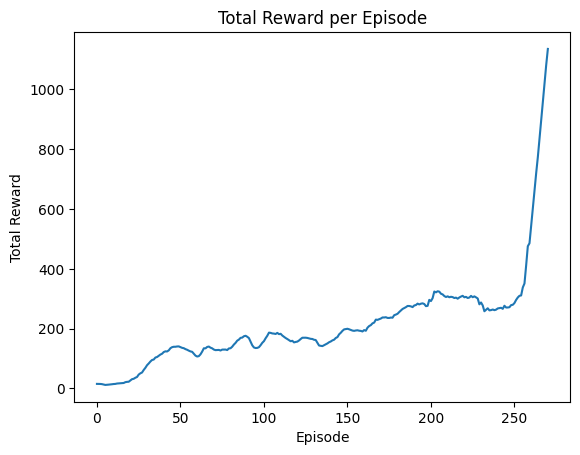

In [ ]:
def moving_average(data, window_size):
    """
    Calculate the moving average of a given list of numbers.

    Parameters:
    - data: List of numbers.
    - window_size: Size of the moving window.

    Returns:
    - List of moving averages.
    """
    if len(data) < window_size:
        return []

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        moving_averages.append(window_average)

    return moving_averages

ma = moving_average(episode_rewards,30)

# Plot cumulative rewards
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()